In [1]:
#import libraries
import pandas as pd
import numpy as np   #pandas is built on numpy
import matplotlib.pyplot as plt
import seaborn as sns
import os
import shap
from sklearn.preprocessing import LabelEncoder, StandardScaler
from scipy.stats import skew
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (classification_report, roc_auc_score, precision_score,recall_score, f1_score, confusion_matrix, accuracy_score, precision_recall_curve,average_precision_score)
from sklearn.metrics import roc_curve, auc, ConfusionMatrixDisplay
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
from sklearn.svm import SVC, LinearSVC
from xgboost import XGBClassifier
import time
from sklearn.decomposition import PCA
from sklearn.linear_model import SGDClassifier
import sys
from sklearn.linear_model import LogisticRegression
from imblearn.pipeline import Pipeline
%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
folder_path = "/content/drive/MyDrive/2012dataset"

In [4]:
file_paths={
    'Sat':f'{folder_path}/TestbedSatJun12Flows.csv',
    'Sun':f'{folder_path}/TestbedSunJun13Flows.csv',
    'Mon':f'{folder_path}/TestbedMonJun14Flows.csv',
    'Tue':f'{folder_path}/TestbedTueJun15Flows.csv',
    'Wed':f'{folder_path}/TestbedWedJun16Flows.csv',
    'Thu':f'{folder_path}/TestbedThuJun17Flows.csv'
} #dictionary
frames=[]
for day,path in file_paths.items():
    df_2012=pd.read_csv(path)
    df_2012['day']=day
    frames.append(df_2012)

df=pd.concat(frames,ignore_index=True)
pd.set_option('display.max_columns',None)

In [5]:
session_df=['totalSourceBytes','totalDestinationBytes','totalSourcePackets','totalDestinationPackets','direction','sourceTCPFlagsDescription',
    'destinationTCPFlagsDescription','protocolName','sourcePort','destinationPort'] #drop time because it does not help the model according to SHAP
                                                                                    #analysis performed and over 83% are zero duration sessions
df=df[session_df+['Label','day']] #keeping day for more analysis later
df=df.copy()

In [6]:
#packet ratio
df['packet_ratio']=df['totalSourcePackets']/df['totalDestinationPackets'].replace(0,np.nan)
df['packet_ratio']=df['packet_ratio'].fillna(0).clip(upper=10)

#byte ratio
df['byte_ratio']=df['totalSourceBytes']/df['totalDestinationBytes'].replace(0,np.nan)
df['byte_ratio']=df['byte_ratio'].fillna(0).clip(upper=10)

#average packet size source
df['avg_packet_size_src']=df['totalSourceBytes']/df['totalSourcePackets'].replace(0,np.nan)
df['avg_packet_size_src']=df['avg_packet_size_src'].fillna(0).clip(upper=1500)

#average packet size destination
df['avg_packet_size_dst']=df['totalDestinationBytes']/df['totalDestinationPackets'].replace(0,np.nan)
df['avg_packet_size_dst']=df['avg_packet_size_dst'].fillna(0).clip(upper=1500)

In [7]:
cat_cols=['direction','sourceTCPFlagsDescription','destinationTCPFlagsDescription','protocolName']
for col in cat_cols:
    df[col] = df[col].fillna("UNKNOWN")

label_encoders = {}
label_mappings = {}

for col in cat_cols:
    le = LabelEncoder()
    df[ col] = le.fit_transform(df[col])
    label_encoders[col] = le
    label_mappings[col] = dict(zip(le.transform(le.classes_), le.classes_))

for col, mapping in label_mappings.items():
    mapping_df = pd.DataFrame(list(mapping.items()), columns=['Code', 'Category'])

print("Mappings completed.")

Mappings completed.


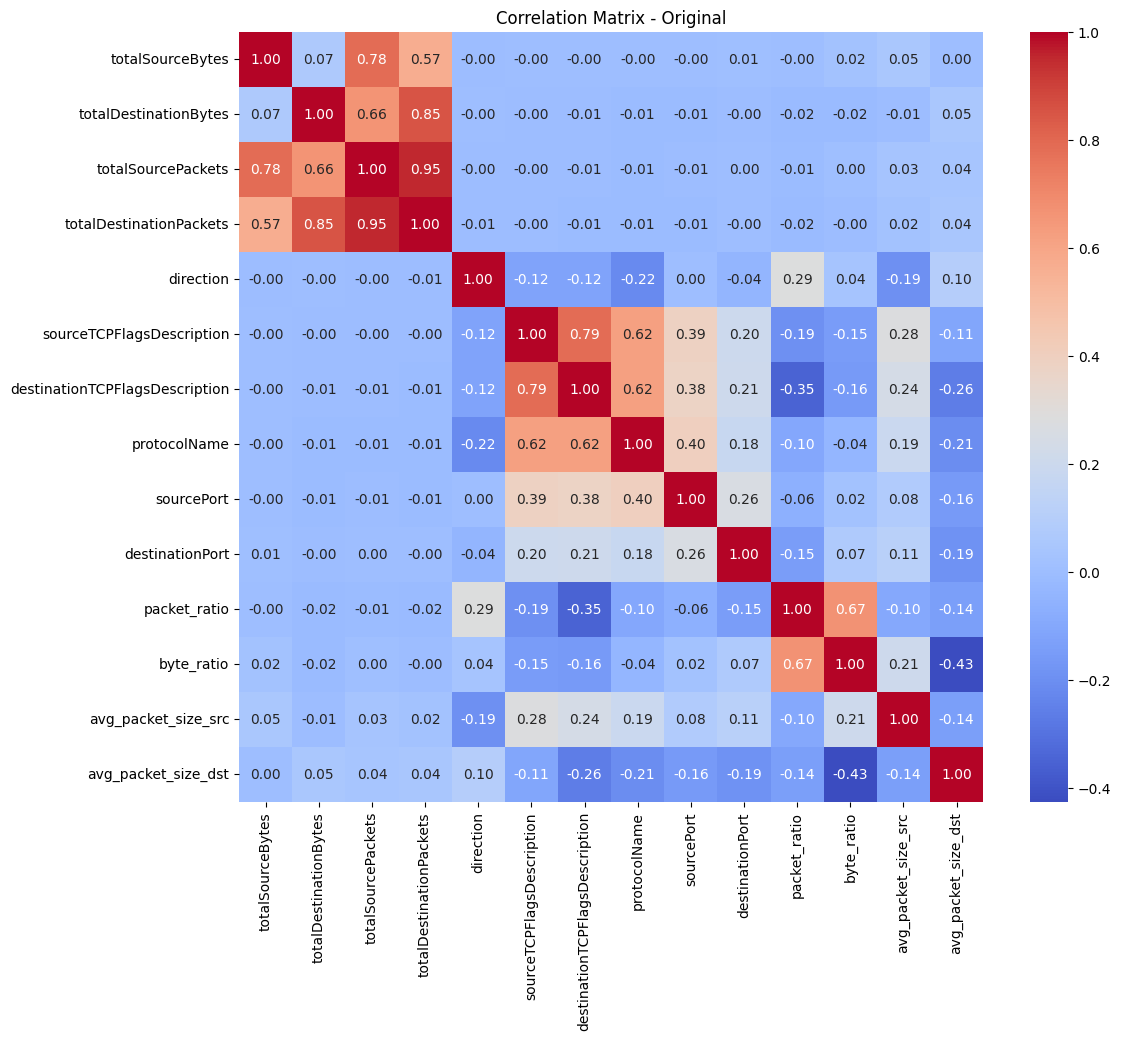

In [8]:
# Correlation matrix on original columns
numeric_cols = df.select_dtypes(include=np.number)
corr_matrix = numeric_cols.corr()

# Visualize
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix - Original")
plt.show()

In [9]:
def drop_highly_correlated(df, threshold=0.95):
    corr_matrix = df.corr().abs()
    upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

    # Find columns with correlation above threshold
    to_drop = [column for column in upper_triangle.columns if any(upper_triangle[column] > threshold)]
    df_reduced = df.drop(columns=to_drop)

    print(f"Dropped {len(to_drop)} columns due to high correlation: {to_drop}")
    return df_reduced

In [10]:
# Apply to original dataset
df_numeric = df.select_dtypes(include=np.number)
df_reduced = drop_highly_correlated(df_numeric)
df_model_original = pd.concat([df_reduced, df["Label"]], axis=1)

Dropped 1 columns due to high correlation: ['totalDestinationPackets']


In [11]:
# Train/Test Split
X = df_model_original.drop("Label", axis=1)
y = df_model_original["Label"].map({"Normal": 0, "Attack": 1})

X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

# CV Comparison Function
def compare_models_cv(models, X_train, y_train, scoring=None, cv=5, verbose=True):
    if scoring is None:
        scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']

    results = {}
    for name, model in models.items():
        cv_result = cross_validate(model, X_train, y_train,
                                   scoring=scoring, cv=cv,
                                   return_train_score=True)
        mean_scores = {}
        for metric in scoring:
            mean_scores[f"train_{metric}"] = round(cv_result[f'train_{metric}'].mean(), 4)
            mean_scores[f"test_{metric}"] = round(cv_result[f'test_{metric}'].mean(), 4)

        results[name] = mean_scores

        if verbose:
            print(f"\n{name} CV scores:")
            for metric in scoring:
                print(f"  {metric}: train={mean_scores[f'train_{metric}']}, "
                      f"test={mean_scores[f'test_{metric}']}")

    return pd.DataFrame(results).T

In [12]:
# Test Evaluation Function
def evaluate_models_test(models, X_train, y_train, X_test, y_test):
    plt.figure(figsize=(8, 6))

    for name, model in models.items():
        # Train on full training set
        model.fit(X_train, y_train)

        # Predictions
        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)[:, 1]

        # Reports
        print(f"\n{name} Test Results:")
        print(classification_report(y_test, y_pred,digits=4))
        print(f"AUC: {roc_auc_score(y_test, y_proba):.4f}")
        print(f"Average Precision: {average_precision_score(y_test, y_proba):.4f}")
        print("Confusion Matrix:")
        print(confusion_matrix(y_test, y_pred))

        # PR curve
        precision, recall, _ = precision_recall_curve(y_test, y_proba)
        plt.plot(recall, precision, label=name)

    plt.title("Precision-Recall Curve (Test Set)")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.legend()
    plt.grid()
    plt.show()



Baseline RF CV scores:
  accuracy: train=0.9995, test=0.9992
  precision: train=0.9891, test=0.9848
  recall: train=0.9946, test=0.9909
  f1: train=0.9919, test=0.9878
  roc_auc: train=1.0, test=0.9998

Weighted RF CV scores:
  accuracy: train=0.999, test=0.9988
  precision: train=0.9737, test=0.9716
  recall: train=0.9976, test=0.9944
  f1: train=0.9855, test=0.9829
  roc_auc: train=1.0, test=0.9999

SMOTE + RF CV scores:
  accuracy: train=0.9989, test=0.9988
  precision: train=0.9722, test=0.9694
  recall: train=0.997, test=0.9951
  f1: train=0.9844, test=0.9821
  roc_auc: train=0.9999, test=0.9998

Cross-validation summary:
             train_accuracy  test_accuracy  train_precision  test_precision  \
Baseline RF          0.9995         0.9992           0.9891          0.9848   
Weighted RF          0.9990         0.9988           0.9737          0.9716   
SMOTE + RF           0.9989         0.9988           0.9722          0.9694   

             train_recall  test_recall  train_f

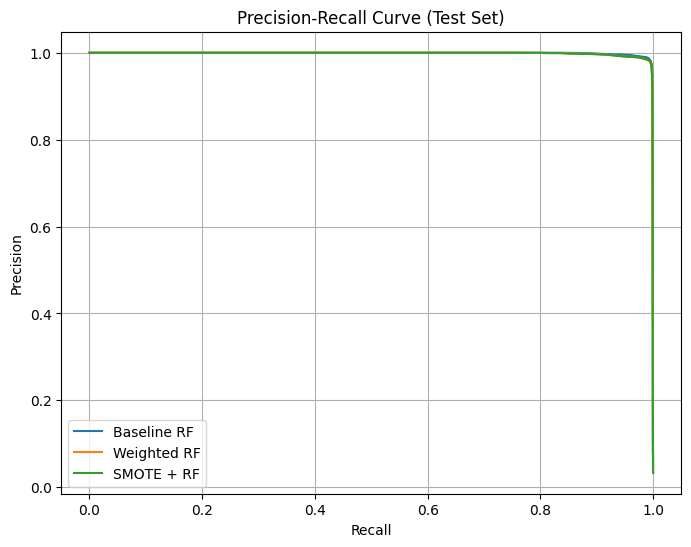

In [13]:
# Define Models
rf_params = {'n_estimators': 50, 'max_depth': 15, 'n_jobs': -1, 'random_state': 42}
models = {
    "Baseline RF": RandomForestClassifier(**rf_params),
    "Weighted RF": RandomForestClassifier(class_weight='balanced', **rf_params),
    "SMOTE + RF": Pipeline([
        ('smote', SMOTE(random_state=42)),
        ('rf', RandomForestClassifier(**rf_params))
    ])
}

# Cross-validation on training set
cv_summary = compare_models_cv(models, X_train, y_train)
print("\nCross-validation summary:")
print(cv_summary)

# Final evaluation on untouched test set
evaluate_models_test(models, X_train, y_train, X_test, y_test)